1. Setup and Load Data

1.1 Install Dependencies and Setup

In [16]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 400
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are on CoLab and successfully using the GPU, this print should
#   contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


In [30]:
class MyDataset(Dataset):
    def __init__(self):
        self.data_files = os.listdir('../HMEI2023-bxliu-data/image_cats')

    def __getitem__(self, idx):
        filename = self.data_files[idx]
        f = os.path.join('../HMEI2023-bxliu-data/image_cats', filename)
        data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
        data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
        data = np.expand_dims(data, axis=2)

        data = np.moveaxis(data, -1, 0)

        matfile = '../HMEI2023-bxliu-data/value_cats/' + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)
        return data, mat['th0'][0]

    def __len__(self):
        return len(self.data_files)

In [31]:
all_data = MyDataset()
print(type(all_data))
train, val, test = torch.utils.data.random_split(all_data, [0.75, 0.125, 0.125])
print(type(train))

<class '__main__.MyDataset'>
<class 'torch.utils.data.dataset.Subset'>


In [32]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

Load Data

In [8]:
# import tqdm

# os.chdir('../HMEI2023-bxliu-data/')

# image_list = []
# theta_list = []

# image_directory = 'image_cats'
# value_directory = 'value_cats/'

# # iterate over files in
# # that directory
# for filename in tqdm.tqdm(os.listdir(image_directory)):
#     # print(filename)
#     f = os.path.join(image_directory, filename)
#     # checking if it is a file
#     if os.path.isfile(f):
#         # color
#         # image = Image.open(f)
#         # data = np.asarray(image)

#         # gray scale
#         data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
#         data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
#         data = np.expand_dims(data, axis=2)

#         matfile = value_directory + filename[:len(filename) - 4] + '.mat'
#         mat = scipy.io.loadmat(matfile)
#         image_list.append(data)
#         theta_list.append(mat['th0'][0])

# print(image_list[0].shape)
# print(theta_list[0])

# theta_list = np.asarray(theta_list)
# image_list = np.asarray(image_list)

# image_list = np.moveaxis(image_list, -1, 1)
# theta_list = np.moveaxis(theta_list, -1, 1)

# print(image_list.shape)

# image_list = torch.tensor(image_list).float()

# theta_list = torch.tensor(theta_list)

# os.chdir('../HMEI2023-bxliu/')

In [9]:
# # normalize data:

# # images
# imean = torch.std(image_list, dim=0)
# istd = torch.mean(image_list, dim=0)
# # image_tensor = torch.div(torch.sub(image_list, imean), istd)
# image_tensor = torch.div(image_list, 255).float()
# print(image_tensor)

# # theta
# tmean = torch.std(theta_list, dim=0)
# tstd = torch.mean(theta_list, dim=0)
# theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
# # theta_tensor = theta_list.float()
# print(theta_tensor)

In [10]:
# full_dataset = TensorDataset(image_tensor, theta_tensor)

# train, val, test = torch.utils.data.random_split(full_dataset, [0.75, 0.125, 0.125])
# train_loader = DataLoader(train, batch_size=42, shuffle=False)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test, batch_size=2, shuffle=False)

In [33]:
print(train_loader)
print(val_loader)
print(test_loader)

In [ ]:
# image_train, image_test, theta_train, theta_test = train_test_split(image_tensor, theta_tensor)

In [ ]:
# print(len(image_train))
# print(len(image_test))

In [ ]:
# train_dataset = TensorDataset(image_train, theta_train)
# print(train_dataset)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# print(train_loader)

# test_dataset = TensorDataset(image_test, theta_test)
# print(test_dataset)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# print(test_loader)

Make Network

In [34]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 128*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) 
            x = self.pool2(F.relu(self.conv2(x))) 
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x)) 
            x = self.fc3(x)
            return x

In [35]:
##ASSERT: checks if CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 1 channel, 128-by-128
    test_data = torch.rand(100,1,128,128)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out)
    print(out.size())
    assert(out.size()==(100,3))

    print(out[0][0])

tensor([[-0.0654, -0.0543, -0.0498],
        [-0.0637, -0.0547, -0.0491],
        [-0.0665, -0.0543, -0.0501],
        [-0.0640, -0.0546, -0.0497],
        [-0.0644, -0.0552, -0.0487],
        [-0.0647, -0.0525, -0.0490],
        [-0.0645, -0.0540, -0.0501],
        [-0.0638, -0.0542, -0.0502],
        [-0.0630, -0.0557, -0.0489],
        [-0.0646, -0.0544, -0.0500],
        [-0.0660, -0.0544, -0.0498],
        [-0.0639, -0.0547, -0.0500],
        [-0.0638, -0.0547, -0.0495],
        [-0.0649, -0.0529, -0.0492],
        [-0.0658, -0.0526, -0.0509],
        [-0.0637, -0.0528, -0.0494],
        [-0.0657, -0.0541, -0.0493],
        [-0.0640, -0.0542, -0.0500],
        [-0.0648, -0.0537, -0.0504],
        [-0.0660, -0.0548, -0.0509],
        [-0.0653, -0.0540, -0.0506],
        [-0.0651, -0.0545, -0.0503],
        [-0.0655, -0.0541, -0.0489],
        [-0.0639, -0.0554, -0.0501],
        [-0.0648, -0.0543, -0.0494],
        [-0.0644, -0.0538, -0.0495],
        [-0.0643, -0.0545, -0.0497],
 

Make trainer for training network

In [36]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None, val_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train(self,epochs):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            epoch_train_loss = 0.0
            epoch_val_loss = 0.0
            epoch_train_steps = 0
            epoch_val_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,3,128,128) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # print(X[0])
                # plt.imshow(np.moveaxis(X[0].cpu().numpy(), 0, -1))

                
                # Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # Getting the output of the Network
                out = self.net(X)

                # Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # Backpropagate to compute gradients of parameteres
                loss.backward()

                # Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_train_loss += loss.item()
                epoch_train_steps += 1
            
            # validation
            self.net.eval()
            for data in val_loader:
                X = data[0].to(device)
                y = data[1].to(device)
        
                out = self.net(X)
                loss = self.loss_function(out, y)
                epoch_val_loss += loss.item()
                epoch_val_steps += 1

            # average loss of epoch
            train_losses.append(epoch_train_loss / epoch_train_steps)
            print("epoch [%d]: train loss %.3f" % (epoch+1, train_losses[-1]))
            val_losses.append(epoch_val_loss / epoch_val_steps)
            print("epoch [%d]: val loss %.3f" % (epoch+1, val_losses[-1]))
        # return train_losses
        return train_losses, val_losses

Train network

In [37]:
### try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### we want the last epoch loss to be less than 0.03
learning_rate = 0.00001 # only nu, only sigma, color, gray, constant nu?, constant rho?, constant sigma?, rand 10 by 200
# learning_rate = 0.0001 # only rho
# learning_rate = 0.000001 # 5 by 400
# learning_rate = 0.000001 # 10 by 200, rand 5 by 400

net = ConvNet()
net = net.to(device)
# opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader, val_loader=val_loader)

train_losses, val_losses = trainer.train(num_epochs)
# train_losses = trainer.train(num_epochs)


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

Plot losses

ValueError: x and y must have same first dimension, but have shapes (500,) and (400,)

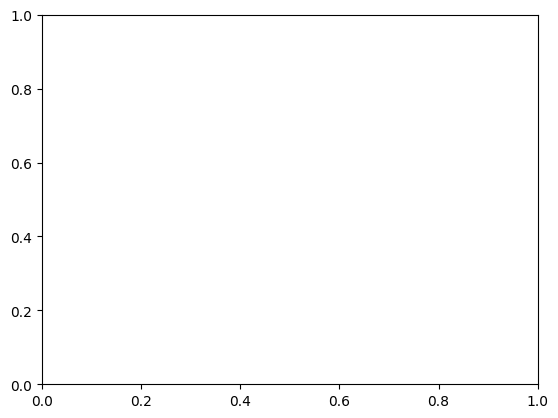

In [ ]:
import matplotlib.pyplot as plt
### plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses computed
plt.plot(range(1,num_epochs+1), train_losses, color = 'red')
plt.plot(range(1,num_epochs+1), val_losses, color = 'blue')
plt.xlabel("epoch number")
plt.ylabel("training loss")

Test network

In [ ]:
hist_array = []
out_array = []
err1 = 0
err2 = 0
err3 = 0
tot = 0
count = 0
with torch.no_grad():
    for data in test_loader:
        # retrieve X and y for this batch, from data, and 
        # move it to the device you are using (probably the GPU)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)

        a = torch.add(torch.mul(output[0], tstd.to(device)), tmean.to(device))
        b = torch.add(torch.mul(y[0], tstd.to(device)), tmean.to(device))

        print("###################################################")
        print(a)
        print(b)
        # print(output[0])
        # print(y[0])
        print("###################################################")

        hist_array.append(a.cpu().numpy() - b.cpu().numpy())
        out_array.append(a.cpu().numpy())
        
        # let the maximum index be our predicted class
        # _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        # err += (y != yh).sum()

        errors = output.sub(y).multiply(output.sub(y)).div(2).sum(axis=0)
        err1 += errors[0]
        err2 += errors[1]
        err3 += errors[2]
        count += 1

print(tot)
print(err1/count)
print(err2/count)
print(err3/count)

print('Accuracy of prediction on test (1): %5.2f%%' % (100-100 * err1 / tot))

print('Accuracy of prediction on test (2): %5.2f%%' % (100-100 * err2 / tot))

print('Accuracy of prediction on test (3): %5.2f%%' % (100-100 * err3 / tot))

###ASSERTS
# assert((100-100 * err / tot)>=98)
# assert(tot==10*1000)

###################################################
tensor([9.2662e+05, 9.4158e-01, 9.4191e+03], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000e+06, 1.0000e+00, 1.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([1.6500e+06, 1.6467e+00, 1.7421e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.5000e+06, 1.5000e+00, 2.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([4.9737e+05, 4.8538e-01, 1.8938e+04], device='cuda:0',
       dtype=torch.float64)
tensor([5.0000e+05, 5.0000e-01, 2.0000e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([9.1151e+05, 9.2789e-01, 2.3247e+04], device='cuda:0',
       dtype=torch.float64)
tensor

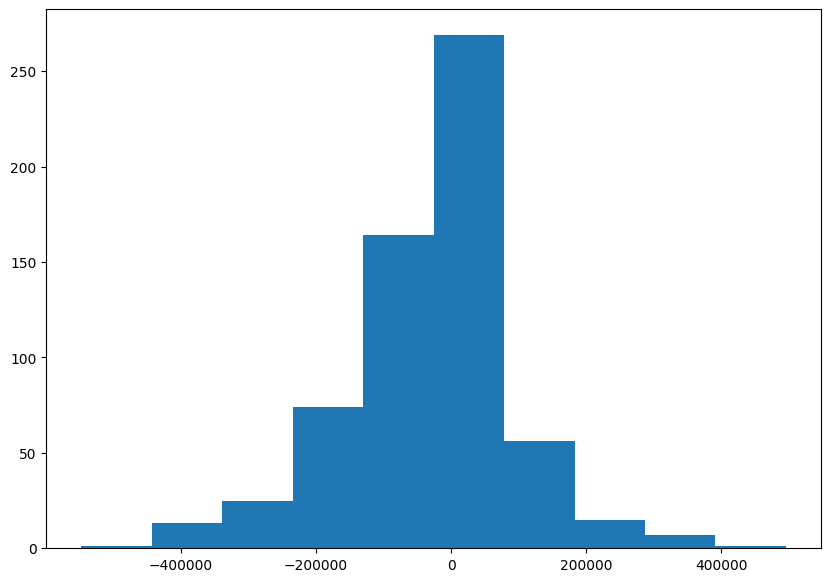

In [ ]:
hist_array = np.array(hist_array)
a = hist_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

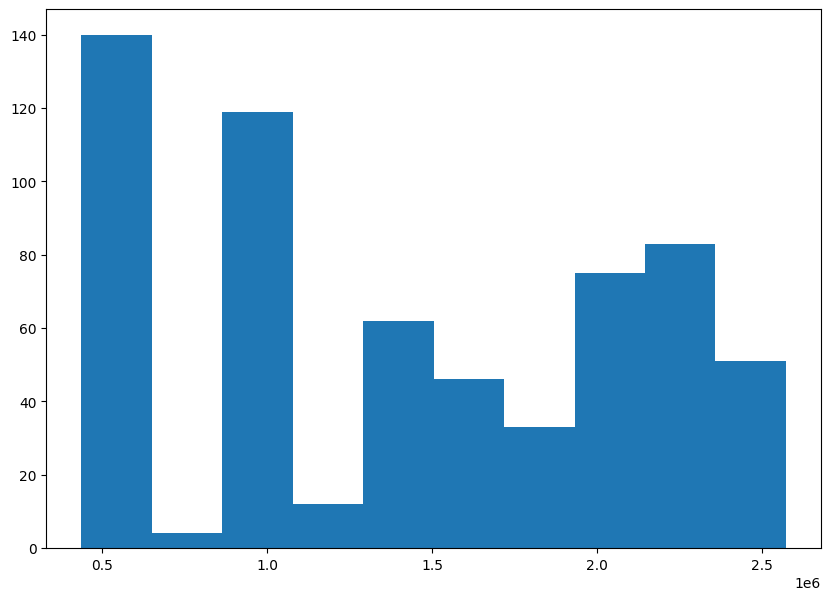

In [ ]:
out_array = np.array(out_array)
a = out_array[:, 0]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

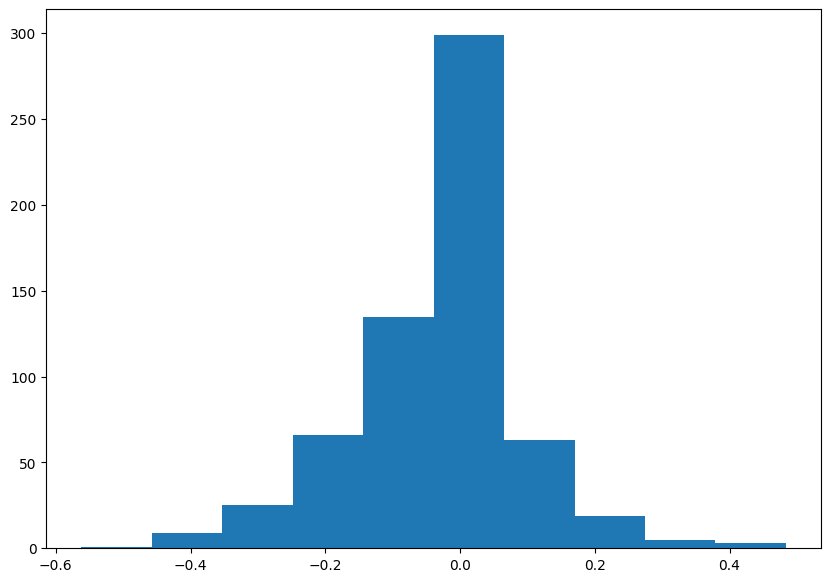

In [ ]:
a = hist_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

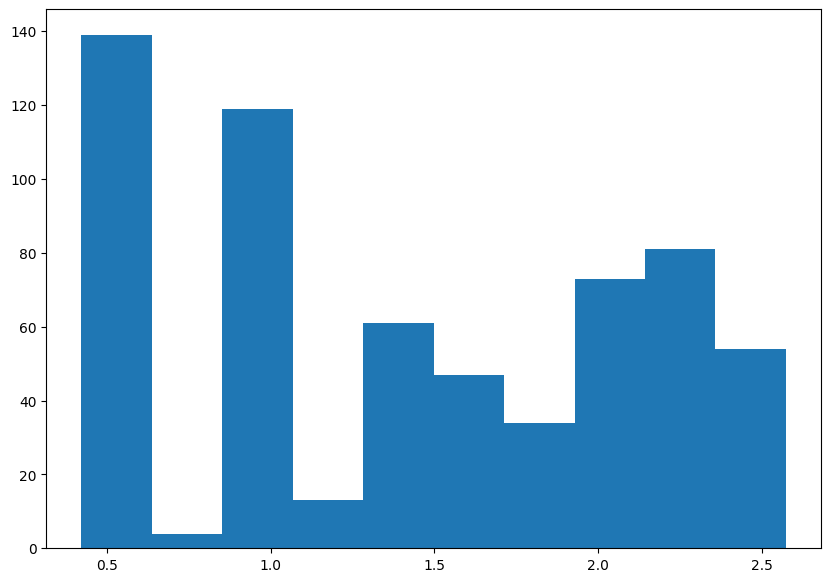

In [ ]:
a = out_array[:, 1]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

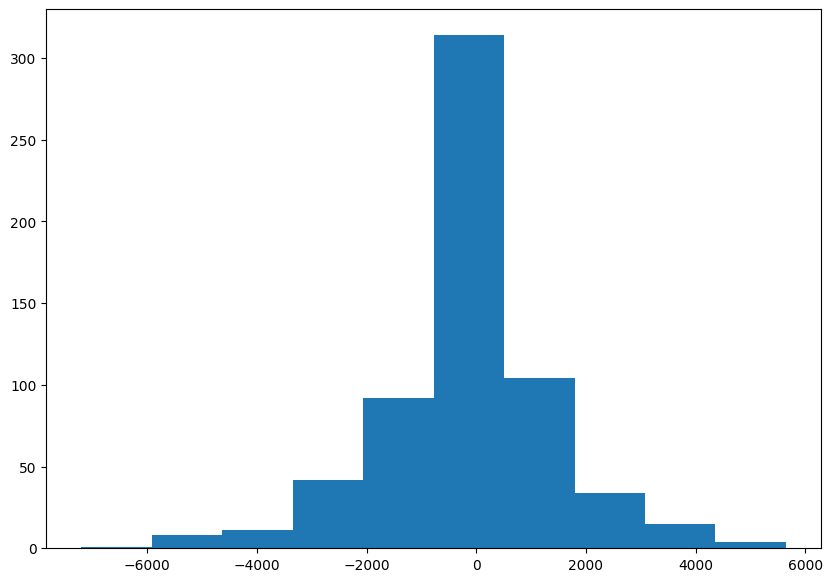

In [ ]:
a = hist_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

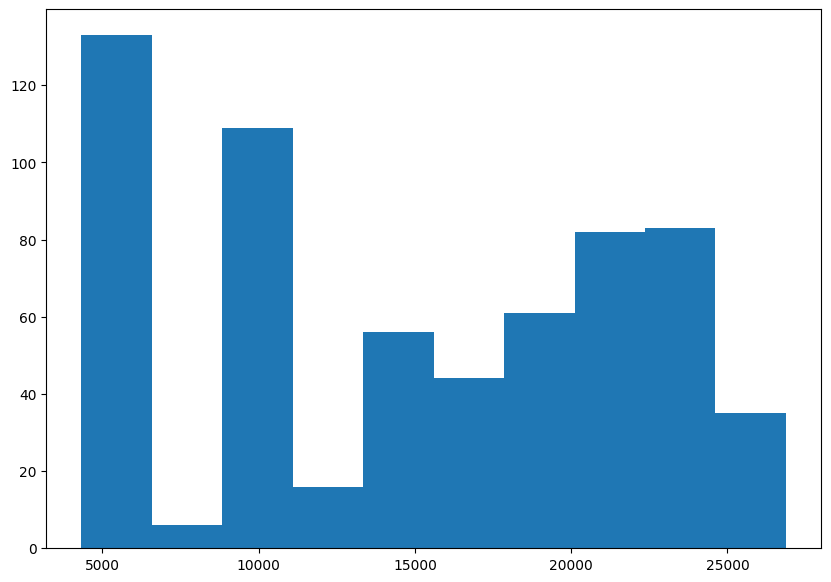

In [ ]:
a = out_array[:, 2]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a)
 
# Show plot
plt.show()

In [ ]:
# os.chdir('../HMEI2023-bxliu-models/')
# save_file = 'only_sigma.pt'
# torch.save(net.state_dict(), save_file)

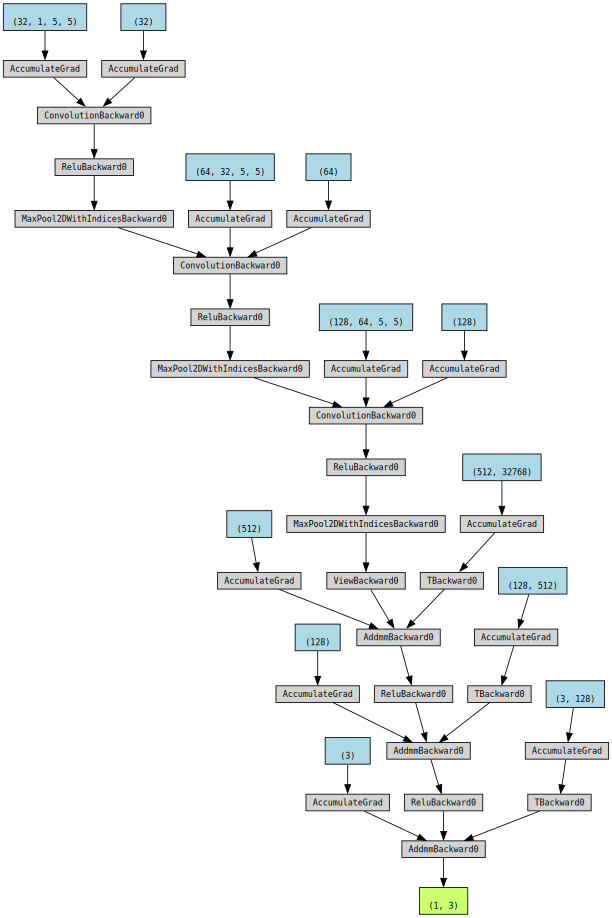

In [ ]:
test_data = torch.rand(1,1,128,128)
test_net = ConvNet()
out = test_net.forward(test_data)
make_dot(out)

Next Steps:
custom loss function (later)
documentation (done)
validation (done-ish, needs going thru again with all the datasets probably)
more data (done)
graph outputs not just loss (done)
outside training set for 5by400 and 10by200



In [ ]:
f = '../HMEI2023-bxliu-data/image_rand_10by200/gentrain_1001.png'
data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
data = cv2.resize(data, (64,64), interpolation=cv2.INTER_CUBIC)
data = np.expand_dims(data, axis=2)
print(data.shape)
# out = net.forward()

(128, 128, 1)


In [ ]:
print(net)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
def use_net(im_data):
    l = []
    l.append(im_data)
    l = np.asarray(l)
    l = np.moveaxis(l, -1, 1)
    print(l.shape)
    l = torch.tensor(l).float()
    l = torch.div(l, 255).float()
    l = l.to(device)
    print(l.shape)
    print(l)
    print(l.stride())
    

    with torch.no_grad():  
        test_data = torch.rand(1,1,128,128).to(device)
        test_data[0] = l[0]
        print(test_data.shape)
        print(test_data)
        print(test_data.stride())
        out = net.forward(test_data)
        # out = net.forward(l)
        out = torch.add(torch.mul(out[0], tstd.to(device)), tmean.to(device))
    return out

In [ ]:
use_net(data)

(1, 1, 128, 128)
torch.Size([1, 1, 128, 128])
tensor([[[[0.7294, 0.7451, 0.6000,  ..., 0.5216, 0.5569, 0.5529],
          [0.7412, 0.7569, 0.6039,  ..., 0.5216, 0.5529, 0.5529],
          [0.6314, 0.6392, 0.5686,  ..., 0.5373, 0.5725, 0.5686],
          ...,
          [0.3137, 0.2902, 0.5216,  ..., 0.3804, 0.8549, 0.8078],
          [0.4902, 0.4980, 0.4275,  ..., 0.5373, 0.7176, 0.6980],
          [0.4863, 0.4902, 0.4196,  ..., 0.5333, 0.7137, 0.6941]]]],
       device='cuda:0')
(16384, 1, 128, 1)
torch.Size([1, 1, 128, 128])
tensor([[[[0.7294, 0.7451, 0.6000,  ..., 0.5216, 0.5569, 0.5529],
          [0.7412, 0.7569, 0.6039,  ..., 0.5216, 0.5529, 0.5529],
          [0.6314, 0.6392, 0.5686,  ..., 0.5373, 0.5725, 0.5686],
          ...,
          [0.3137, 0.2902, 0.5216,  ..., 0.3804, 0.8549, 0.8078],
          [0.4902, 0.4980, 0.4275,  ..., 0.5373, 0.7176, 0.6980],
          [0.4863, 0.4902, 0.4196,  ..., 0.5333, 0.7137, 0.6941]]]],
       device='cuda:0')
(16384, 16384, 128, 1)


tensor([2.4816e+06, 2.4836e+00, 4.7060e+03], device='cuda:0',
       dtype=torch.float64)

In [ ]:
matfile = '../HMEI2023-bxliu-data/value_rand_10by200/gentrain_1001.mat'
mat = scipy.io.loadmat(matfile)
print(mat['th0'][0])

[3.34650214e+06 2.59287601e+00 4.98000000e+03]
